# Capstone Project - Machine Learning Nanodegree

## Convolutional Neural Networks - Thorax-Pneumonia Classifier

---

### Introduction

In this notebook, we are developing a deep learning classification algorithm. Specific models learn a mapping between input features and class labels. The coding shall accept any future (posterior-anterior, anterior-posterior orientations) X-ray chest image as input for estimation of having a pneumonia chest image or not. Regarding the underlying dataset, we are solving such binary classification question for .jpeg compressed X-ray chest images mostly from children. This dataset used for analysis comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/version/2). Such kind of analysis result improves the medical diagnostic workflow. As a future improvement, the algorithm could be used for all human age categories and X-ray orientations including lateral chest images, but such images are not available by now.

![Image Samples](images/lung_images_pair_small.PNG)


For official companies the medical software development happened as part of a regulatory domain. So, let us assume, we would like to use the algorithm as a component of an official product. Then notified bodies would proof the algorithm and its concept regarding quality and regulatory aspects. From technical point of view, working with medical images the CNN concept is the state-of-the-art approach. On the other hand, for getting an official permission and its discussion, the comparison and benchmark of several network architectures and parameter changes together with explanations would help. So, let us do this now, but have in mind that because of technical constraints this solution is not the best one. With better hardware conditions, several neural network optimisations are possible. E.g. it is expected to have a test accuracy much higher 90%.


For implementation on Windows OS, we use Python 3.6 with Keras and TensorFlow as backend. For plotting the network architecture the pydot library and Graphviz2.38 shall be installed and properly configured (see [readme](https://github.com/IloBe/CNN_Thorax-Pneumonia_Classifier/blob/master/README.md)).

---

### Navigation Content

* [Step 0](#step0): Import Libraries and Reproducibility
* [Step 1](#step1): Import Chest Dataset
* [Step 2](#step2): Data Exploration
* [Step 3](#step3): Data Pre-Processing
* [Step 4](#step4): Create a CNN Model from the Scratch (Basic Model)
* [Step 5](#step5): Last Basic Model with Augmentation
* [Step 6](#step6): Such Basic Model with Adam as Optimiser
* [Step 7](#step7): Last Basic Model with Adam and Augmentation
* [Step 8](#step8): Create an improved CNN Model with Adam
* [Step 9](#step9): Last improved CNN Model with Augmentation
* [Step 10](#step10): Create a ResNet CNN Model with Transfer Learning
* [Step 11](#step11): Fine-tuned Transfer Learning ResNet CNN Model with Augmentation
* [Step 12](#step12): Create an InceptionV3 CNN Model with Transfer Learning
* [Step 13](#step13): Evaluation
* [Step 14](#step14): Benchmark and Conclusion


---
<a id='step0'></a>
## Step 0: Import Libraries and Reproducibility

### Import Libraries
Import libraries needed to implement the algorithm for this Chest image classifier. Finally, set random seed to make the results reproducible. Note: running this code the first time, a message pops up that TensorFlow backend is used.

In [53]:
from sklearn.datasets import load_files 
from sklearn import metrics
from glob import glob
from tqdm import tqdm
from PIL import ImageFile

from keras.utils import np_utils, plot_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K

from models.Model import Model
from Evaluation_Class import Evaluation_Class

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt                        
%matplotlib inline 

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Make the Code Reproducible 

According Keras documentation this additional coding is necessary to make the results reproducible.

In [4]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(1042)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

<a id='step1'></a>
## Step 1: Import Chest Dataset

In the code cell below, we import a dataset of chest images. The images distributions of the training, validation and testing sets are stored as .csv files. 

We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `chest_names` - list of string-valued chest names (NORMAL, PNEUMONIA) for translating labels

In [5]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/chest_xray/train')
valid_files, valid_targets = load_dataset('data/chest_xray/val')
test_files, test_targets = load_dataset('data/chest_xray/test')

# load list of chest names (NORMAL, PNEUMONIA)
chest_names = [item[20:-1] for item in sorted(glob("data/chest_xray/train/*/"))]

In [6]:
print(valid_files)

['data/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
 'data/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'
 'data/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg']


In [7]:
# store the dataset files as csv, so, distribution of train-validation-test datasets are reproducible
# file names have to be changed according the used specific datasets distribution

train_df = pd.DataFrame(train_files)
valid_df = pd.DataFrame(valid_files)
test_df = pd.DataFrame(test_files)

train_df.to_csv(path_or_buf="./requirements/train_original.csv", index=False)
valid_df.to_csv(path_or_buf="./requirements/valid_original.csv", index=False)
test_df.to_csv(path_or_buf="./requirements/test_original.csv", index=False)

<a id='step2'></a>
## Step 2: Data Exploration

Some statistical information about the dataset of chest images. 

In [8]:
def get_percentage(total, other):
    return (other*100)/total    

In [9]:
# print statistics about the dataset
# print('There are {} total chest categories, called: {}, {}.'.format(len(chest_names),chest_names[0],chest_names[1]))
print('There are %d total chest categories' % len(chest_names))  # there are only 2
total = len(np.hstack([train_files, valid_files, test_files]))
print('There are %s total chest images.\n' % (total))
print('There are %d training chest images: %.3f%%' % (len(train_files),
                                                      get_percentage(total, len(train_files))))
print('There are %d validation chest images: %.3f%%' % (len(valid_files),
                                                        get_percentage(total, len(valid_files))))
print('There are %d test chest images: %.3f%%'% (len(test_files),
                                                 get_percentage(total, len(test_files))))

There are 2 total chest categories
There are 5856 total chest images.

There are 5216 training chest images: 89.071%
There are 16 validation chest images: 0.273%
There are 624 test chest images: 10.656%


**Note:**<br>
According the original dataset 89.07% are training images and only 10.66% are test images. This doesn't fit to the rule-of-thumb to use a training/testing separation of 70/30 or 80/20 percent. 
But first, we will have look how the results for the different CNN are working with this original dataset.

How are the categories labelled? Regarding the images, for the different training, testing and validation pneumonia data samples, the images are labelled with 'virus' and 'bacteria' as root cause. This information is part of the image name text string. How many are there from each root cause category? The categories are ...

In [10]:
# What kind of chest categories exist?
chest_names

['n/NORMAL', 'n/PNEUMONIA']

What is the structure of the files from the different directories, means how many images from each category are available in the train, validation and test directories?

In [11]:
def get_category_counter(file):
    ''' delivers the amount of normal or pneumonia images '''
    counter_normal = 0
    counter_pneumonia = 0
    file_array = file
    pneumonia_files = []
        
    for item in file_array[:]:
        if 'NORMAL' in item:
            counter_normal += 1
        else: # PNEUMONIA case
            # add item to array and increase counter
            pneumonia_files.append(item)
            counter_pneumonia += 1
               
    return counter_normal, counter_pneumonia, pneumonia_files

count_train_normal, count_train_pneumonia, train_pneumonia_files = get_category_counter(train_files)
count_valid_normal, count_valid_pneumonia, valid_pneumonia_files = get_category_counter(valid_files)
count_test_normal, count_test_pneumonia, test_pneumonia_files = get_category_counter(test_files)

print("--- Train files ---")        
print("{} normal chest images.".format(count_train_normal))
print("{} pneumonia chest images.".format(count_train_pneumonia))

print("\n--- Validation files ---")        
print("{} normal chest images.".format(count_valid_normal))
print("{} pneumonia chest images.".format(count_valid_pneumonia))

print("\n--- Test files ---")        
print("{} normal chest images.".format(count_test_normal))
print("{} pneumonia chest images.".format(count_test_pneumonia))

--- Train files ---
1341 normal chest images.
3875 pneumonia chest images.

--- Validation files ---
8 normal chest images.
8 pneumonia chest images.

--- Test files ---
234 normal chest images.
390 pneumonia chest images.


For the original dataset:<br>
This distribution is much clearer if visualised in bar charts. Nevertheless, there is a clear tendency of having pneumonia images, especially for the training dataset where the ratio normal : pneumonia is 1 : 2.89.
So, it is not heavily imbalanced. Furthermore, there are very less validation samples. In general, it is expected to have more, nearly the same amount as the test files.

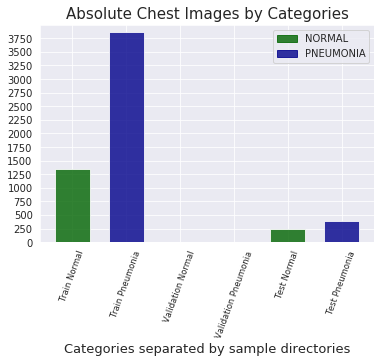

In [12]:
# Visualise all the findings
locations = [0, 1, 2, 3, 4, 5]
colors = ['darkgreen', 'darkblue', 'darkgreen', 'darkblue', 'darkgreen', 'darkblue']
hights = [count_train_normal, count_train_pneumonia, count_valid_normal, count_valid_pneumonia,
         count_test_normal, count_test_pneumonia]
width = 0.65
label_list = ['Train Normal', 'Train Pneumonia', 'Validation Normal', 'Validation Pneumonia',
              'Test Normal', 'Test Pneumonia']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.yticks(np.arange(0, 4000, 250))
labels = ax.set_xticklabels(label_list, rotation=70, fontsize='small')
plt.bar(locations, hights, width, color=colors, tick_label=labels, alpha=0.8)
plt.ylim([0, 4000])
plt.title('Absolute Chest Images by Categories', fontsize=15)
plt.xlabel('Categories separated by sample directories', fontsize=13)
green_patch = mpatches.Patch(color='darkgreen', label='NORMAL', alpha=0.8)
blue_patch = mpatches.Patch(color='darkblue', label='PNEUMONIA', alpha=0.8)
plt.legend(handles = [green_patch, blue_patch])

**Note:**<br>
In each set there are much more Pneumonia cases compared to the non-Pneumonia ones, especially for the training set. The validation set is too small to be visualised in this diagram.

In [13]:
# For simpler usage, first we have to put the data in a dictionary.
# {'train' : {'Normal' : count_train_normal,
#             'Pneumonia' : count_train_pneumonia},
#  'valid' : {'Normal' : count_valid_normal,
#             'Pneumonia' : count_valid_pneumonia}, 
#  'test' : {'Normal' : count_test_normal, 
#            'Pneumonia' : count_test_pneumonia}}

categories_counter_data = {"Sample" : ["train", "valid", "test"],
                           "Normal" : [count_train_normal, count_valid_normal, count_test_normal],
                           "Pneumonia" : [count_train_pneumonia, count_valid_pneumonia, count_test_pneumonia]}

df_categories = pd.DataFrame(data = categories_counter_data, index = ["train", "valid", "test"])

In [14]:
# Add the amount difference for each category and directory to the dataframe
df_categories['Difference'] = df_categories['Normal'] - df_categories['Pneumonia']

In [15]:
# Visualise the differences compared to category and sample directories,
# therefore use the absolute values of the differences as well to see them on the same positive level
df_categories['Difference_abs'] = df_categories['Difference'] * (-1)
df_categories.head()

,Normal,Pneumonia,Sample,Difference,Difference_abs
train,1341,3875,train,-2534,2534
valid,8,8,valid,0,0
test,234,390,test,-156,156


Now, the relationship of the amount difference between the normal and pneumonia samples are visualised. The associated table above showed that there is no difference value for the validation set, the number of Normal and Pneumonia images is the same.

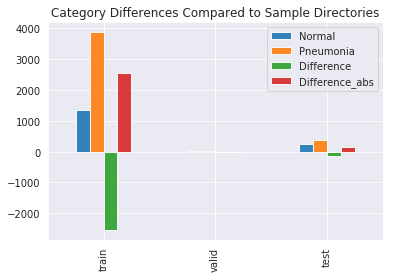

In [16]:
#locations = [0, 1, 2}
x_labels = ['Train', 'Valid', 'Test']

df_categories.plot(title='Category Differences Compared to Sample Directories', kind='bar', tick_label=x_labels, alpha=0.9)

The training set (x label: train) has much more pneumonia cases compared to the normal ones, this is not the case for the testing samples (x label: test) of normal and pneumonia chest images. They look much more balanced.

**Additional question** regarding the different sample directories: How many of the pneumonia chest images have virus or bacteria as _root cause_?

In [17]:
def get_rootcause_counter(files):
    ''' delivers the amount of bacteria or virus pneumonia images '''
    counter_virus = 0
    counter_bacteria = 0
    file_array = files
    
    
    for item in file_array:
        if 'virus' in item:
            counter_virus += 1
        elif 'bacteria' in item:
            counter_bacteria += 1
        else:
            print('{} does not include a root cause in its file name string (virus or bac.')
            
    return counter_virus, counter_bacteria

count_train_virus, count_train_bacteria = get_rootcause_counter(train_pneumonia_files)
count_valid_virus, count_valid_bacteria = get_rootcause_counter(valid_pneumonia_files)
count_test_virus, count_test_bacteria = get_rootcause_counter(test_pneumonia_files)

print("--- Train pneumonia files ---")        
print("{} virus chest images.".format(count_train_virus))
print("{} bacteria chest images.".format(count_train_bacteria))

print("\n--- Validation pneumonia files ---")        
print("{} virus chest images.".format(count_valid_virus))
print("{} bacteria chest images.".format(count_valid_bacteria))

print("\n--- Test pneumonia files ---")        
print("{} virus chest images.".format(count_test_virus))
print("{} bacteria chest images.".format(count_test_bacteria))

--- Train pneumonia files ---
1345 virus chest images.
2530 bacteria chest images.

--- Validation pneumonia files ---
0 virus chest images.
8 bacteria chest images.

--- Test pneumonia files ---
148 virus chest images.
242 bacteria chest images.


**Note:**<br>
In the future, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.

<a id='step3'></a>
## Step 3: Data Pre-Processing

Keras is using TensorFlow as backend, means as tensor manipulation. According the TensorFlow [guide](https://www.tensorflow.org/guide/tensors), a "tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes." 

Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively. The channels value is 1, if the image is a grey-scale image and 3 otherwise (RGB). 


The `path_to_tensor` function below takes a string-valued file path to a chest image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

In [18]:
def path_to_tensor(img_path):
    # loads image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [19]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 624/624 [00:11<00:00, 55.72it/s]


In [20]:
print('The tensor shape of the images is:')
print('Train dataset shape: {}'.format(train_tensors.shape))
print('Validation dataset shape: {}'.format(valid_tensors.shape))
print('Test dataset shape: {}'.format(test_tensors.shape))

The tensor shape of the images is:
Train dataset shape: (5216, 224, 224, 3)
Validation dataset shape: (16, 224, 224, 3)
Test dataset shape: (624, 224, 224, 3)


<a id='step4'></a>
## Step 4: Create a CNN Model from the Scratch (Basic Model)

### Model Implementation

Start creating a basic model with 5 blocks of Convolutional, MaxPooling and Dropout sublayers as hidden layer components. As flatten layer GlobalAveragePooling2D is used. The output Dense layer for the 2 resulting categories NORMAL and PNEUMONIA is using 'softmax' as activation function.

In [21]:
# Define the base model architecture.
# Start with the basic model
base_model_class = Model("Basic", "Basic_CNN_Model", "accuracy")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
______________________________________

### Compile the Model

As optimiser 'rmsprop' with loss function 'binary_crossentropy' and 'accuracy' metric is used. The weights of the model layers will be updated during training.

In [22]:
base_model_class = base_model_class.get_class()
# Is it the expected class?
base_model_class

In [23]:
# use with general optimiser 'rmsprop'
base_model = base_model_class.get_model()
base_model_class.compile_model(model=base_model, optimizer='rmsprop',
                               loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

Model training with use of checkpointing to save the model that attains the best validation loss. The following hyperparameters are set: 
- `epochs` is set to a number of iterations including the point where the network stops learning or start overfitting
- `batch_size` is set to a common minimal size of memory: 32; if your machine is better use 64, 128, 256, ... 

For the original dataset: train on 5216 samples, therefore batch_size=32 => 5216/32 = 163<br>

In [24]:
# specify the number of epochs used to train the model

# regarding the original dataset: 
# train on 5216 samples, therefore batch_size=32 => 5216/32 = 163

base_model_history = base_model_class.train_model(model=base_model, epochs=20, batch_size=32,
                                           filepath='./saved_models/base_model_weights.best.from_scratch.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 16 samples
Epoch 1/20
 - 375s - loss: 3.9938 - acc: 0.7280 - val_loss: 5.9475 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 5.94746, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 2/20
 - 375s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.2197 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 5.94746
Epoch 3/20
 - 374s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.6683 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 5.94746
Epoch 4/20
 - 375s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 5.94746
Epoch 5/20
 - 374s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 5.94746
Epoch 6/20
 - 375s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 5.94746
Epoch 7/20

**Note:**<br>
As visible on all results, the model shows high overfitting and no real learning, it cannot be used for the given task. Would this change by using this model architecture with the augmentation concept?

<a id='step5'></a>
## Step 5 Last Basic Model with Augmentation

### Model Implementation and Training

We are using image data augmentation to decrease the amount of images of our training dataset, and see if there is an improvement to reduce the existing misclassification error. This concept shall improve the performance and the generalisation ability of our network. We want to prevent overfitting. Keras offers already a process to do this, using its ImageDataGenerator object class. The original images are rotated, shifted, zoomed, flipped etc. and by doing this, creating new image mutations. So, the range of images for each epoch increases and the propability that the algorithm sees the same images more than once is much reduced.

Generator handling according the given Keras example using .flow() functionality together with the already created pre-processed tensors instances. With such tensors rescaling by /255 has already happened. The .flow() command generates batches of randomly transformed images.

The generator parameters are set according the image properties, having chest images. E.g. huge zooming or rotation would make no sense, but horizontal flip is fine. 

In general according augmentation information, have a look to the associated Keras classification [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [31]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    rescale=1.,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

validation_generator = ImageDataGenerator(rescale=1)

In [32]:
batch_size = 32
training_data = train_data_generator.flow(train_tensors, train_targets, batch_size=batch_size)
validation_data = validation_generator.flow(valid_tensors, valid_targets, batch_size=batch_size)

In [33]:
model = Model("Basic", "Basic_CNN_Model", "accuracy")
aug_base_model_class = model.get_class()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)         

In [34]:
aug_base_model = aug_base_model_class.get_model()
aug_base_model_class.compile_model(model=aug_base_model, optimizer='rmsprop',
                                   loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
from models.Basic_CNN_Model import Basic_CNN_Model
epochs = 20  # first try
aug_base_model_history = aug_base_model_class.augmentation_train_model(model=aug_base_model,
                                  filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/20
 - 380s - loss: 4.0246 - acc: 0.7278 - val_loss: 7.7318 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 7.73185, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 373s - loss: 4.1213 - acc: 0.7429 - val_loss: 7.7318 - val_acc: 0.5000

Epoch 00002: val_loss improved from 7.73185 to 7.73185, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 3/20
 - 375s - loss: 4.1213 - acc: 0.7429 - val_loss: 7.7318 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 7.73185
Epoch 4/20
 - 393s - loss: 4.1213 - acc: 0.7429 - val_loss: 7.8657 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 7.73185
Epoch 5/20
 - 397s - loss: 4.1213 - acc: 0.7429 - val_loss: 7.8657 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 7.73185
Epoch 6/20
 - 375s - loss: 4.1213 - acc: 0.7429 - val_loss: 7.8657 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 7.73185
Epoch 7/20
 - 376s

<a id='step6'></a>
## Step 6: Such Basic Model with Adam as Optimiser

Adam is another adaptive gradient descent algorithm. It updates the RMSProp optimiser and shall improve the task performance. Less manual tuning of the hyperparameters for the learning rate schedule is necessary.

### Compile and Train the Model

In [36]:
# Start creating as new instance with the basic model
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_base_model_class = model.get_class()
adam_base_model = adam_base_model_class.get_model()
adam_base_model  # must be Sequential instance


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)         

In [37]:
# adam defaults:
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# learn with decay to avoid overfitting, decay=1e-6
adam_base_model_class.set_Adam_params()
adam_base_model_class.compile_model(model=adam_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_base_model = adam_base_model_class.get_model()

In [38]:
# train the model with call of train function
adam_base_model_history = adam_base_model_class.train_model(model=adam_base_model, epochs=20, batch_size = 32,
                                  filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5',
                                  train_tensors=train_tensors, train_targets=train_targets,
                                  valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 5216 samples, validate on 16 samples
Epoch 1/20
 - 363s - loss: 0.4969 - acc: 0.7611 - val_loss: 1.0457 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 1.04565, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 2/20
 - 360s - loss: 0.3629 - acc: 0.8236 - val_loss: 1.6712 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 1.04565
Epoch 3/20
 - 361s - loss: 0.3477 - acc: 0.8317 - val_loss: 1.5467 - val_acc: 0.5625

Epoch 00003: val_loss did not improve from 1.04565
Epoch 4/20
 - 361s - loss: 0.3146 - acc: 0.8627 - val_loss: 1.6066 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 1.04565
Epoch 5/20
 - 362s - loss: 0.2888 - acc: 0.8735 - val_loss: 1.0737 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 1.04565
Epoch 6/20
 - 362s - loss: 0.2555 - acc: 0.8901 - val_loss: 1.1044 - val_acc: 0.6250

Epoch 00006: val_loss did not improve from 1.04565
Epoch 7/20
 - 361s - loss: 0.2246 - acc: 0.9062 -

<a id='step7'></a>
## Step 7: Last Basic Model with Adam and Augmentation

### Model Implementation and Training

In [39]:
# create new instance
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_aug_base_model_class = model.get_class()
adam_aug_base_model = adam_aug_base_model_class.get_model()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)         

In [40]:
adam_aug_base_model_class.set_Adam_params()
adam_aug_base_model_class.compile_model(model=adam_aug_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_aug_base_model = adam_aug_base_model_class.get_model()

In [41]:
epochs = 20
#  still the same: batch_size = 32

# use the same generator instance and flow data as before ...
# valid_tensors.shape[0] -> original dataset: 16 / 32 = 0.5
adam_aug_base_model_history = adam_aug_base_model_class.augmentation_train_model(model=adam_aug_base_model,
                                  filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/20
 - 372s - loss: 0.5594 - acc: 0.7418 - val_loss: 0.7478 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.74775, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 365s - loss: 0.4293 - acc: 0.7690 - val_loss: 0.8178 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.74775
Epoch 3/20
 - 372s - loss: 0.3904 - acc: 0.8064 - val_loss: 0.6587 - val_acc: 0.6250

Epoch 00003: val_loss improved from 0.74775 to 0.65865, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 4/20
 - 365s - loss: 0.3720 - acc: 0.8186 - val_loss: 0.6811 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.65865
Epoch 5/20
 - 363s - loss: 0.3563 - acc: 0.8332 - val_loss: 0.6558 - val_acc: 0.6250

Epoch 00005: val_loss improved from 0.65865 to 0.65580, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 6/20
 - 378s - loss: 0.3283 - acc: 0.8505 - val_loss

<a id='step8'></a>
## Step 8: Create an improved CNN Model with Adam

Now, we train a model having more hidden layers - a more complex architecture - using Adam as optimiser at once, what kind of result will be calculated compared to the last basic model after having done the augmentation improvement? The Adam optimiser is used for learning with binary crossentropy loss function.

Afterwards, we apply the augmentation concept on this improved model and see what kind of performance difference will appear. Is there an improvement compared to the model architecture before?

To know more about improved model architectures the following [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) is available:
'Going Deeper with Convolutions'


### Model Implementation

In [42]:
# Define the improved model architecture.
improved_model = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_class = improved_model.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)    

### Compile the Model

In [43]:
# first try: use Adam optimiser with decay=1e-6 
improved_model = improved_model_class.get_model()
improved_model_class.set_Adam_params()
improved_model_class.compile_model(model=improved_model, optimizer='Adam', loss='binary_crossentropy',
                                   metrics=['accuracy'])

### Train the Model

In [44]:
epochs = 20
batch_size = 32
improved_model_adam = improved_model_class.get_model()
improved_model_history = improved_model_class.train_model(model=improved_model_adam,
                                           epochs=epochs, batch_size=batch_size,
                                           filepath='./saved_models/improved_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 5216 samples, validate on 16 samples
Epoch 1/20
 - 709s - loss: 4.0067 - acc: 0.7345 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 8.01512, saving model to ./saved_models/improved_model_weights.best.withAdam.hdf5
Epoch 2/20
 - 690s - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 8.01512
Epoch 3/20
 - 690s - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 8.01512
Epoch 4/20
 - 690s - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 8.01512
Epoch 5/20
 - 691s - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 8.01512
Epoch 6/20
 - 691s - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 8.01512
Epoch 7/20
 - 691s - loss: 4.1213 - acc: 0.7429 - val_loss

In [ ]:
# plot the improved model to a file and store it for further usage (only first time)
#plot_model(improved_model_adam, to_file='./saved_models/improved_model_withAdam.png')

<a id='step9'></a>
## Step 9:  Last improved CNN Model with Augmentation

We use the same ImageDataGenerator instance and flow function results as before.

In [45]:
# new instance learning on the same dataset with augmentation
improved_model_aug = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_aug_class = improved_model_aug.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)    

### Compile the Model

In [46]:
improved_model_aug = improved_model_aug_class.get_model()
improved_model_aug_class.set_Adam_params(lr=1e-4) # there has been no real learning improvement with the former model
improved_model_aug_class.compile_model(model=improved_model_aug, optimizer='Adam', loss='binary_crossentropy',
                                       metrics=['accuracy'])

### Training with Augmentation

In [51]:
# because the former model does not learn during its training sequence,
# the learning rate is already reduced to lr=1e-4 compared to the default value lr=0.001 used before with the former model
epochs = 20  
batch_size = 32
# generator and generator flow data, training and validation data are the same as before

improved_model_aug_history = improved_model_aug_class.augmentation_train_model(model=improved_model_aug,
                                filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/20
 - 685s - loss: 0.4570 - acc: 0.7467 - val_loss: 0.7292 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.72924, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 677s - loss: 0.3985 - acc: 0.7751 - val_loss: 0.6772 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.72924 to 0.67721, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 3/20
 - 679s - loss: 0.3863 - acc: 0.8029 - val_loss: 0.8293 - val_acc: 0.5625

Epoch 00003: val_loss did not improve from 0.67721
Epoch 4/20
 - 682s - loss: 0.3820 - acc: 0.8108 - val_loss: 0.7110 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.67721
Epoch 5/20
 - 688s - loss: 0.3758 - acc: 0.8131 - val_loss: 0.8480 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.67721
Epoch 6/20
 - 681s - loss: 0.3325 - acc: 0.8447 - val_loss: 0.6423 - val_acc: 0.6875

Epoch 00006: val_loss improved from 0.67721 to 0.64230, savin

<a id='step10'></a>
## Step 10: Create a ResNet CNN Model with Transfer Learning

As sense of transfer learning, Goodfellow et al mentioned in their 'Deep Learning' book "Situation where what has been learned in one setting is exploited to improve generalization in another setting."

We don't have a huge dataset for the given pneumonia classification and more generalised, even not for all human age and X-ray orientation categories. The existing dataset is a specific one for a specific task, therefore we need technical help to improve the classification performance having a good, proper learning result, especially thinking at the 'new, available' image examples of the future.

With a pre-trained model, we use its knowledge even from another domain and task (like for image tasks a pre-trained model from the huge ImageNet database including a lot of different object categories), to let our network learn the new problem. This knowledge transfer is possible, because all images share some same features, like e.g. edges, shapes, zooming or rotation. The common features are learned in the hidden layers from the beginning, the more specific task ones are learned at the end of the hidden layer blocks. To improve our specific classification task we can change the network there and let the first part as learned with the ImageNet database. We don't need our network to learn from scratch. We can freeze such hidden-layer convolutional subblocks and its outputs are the input of the specific classifier block at the end of the network.

Technically, how to do this is e.g. explained in the Keras [documentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).


### Model Implementation and Compilation

First, we create a pre-trained ResNet50 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features. ResNet is a short name for residual network. It includes a lot of subblocks with BatchNormalization layers.

In [100]:
basic_resNet_model = Model("Transfer", "Transfer_ResNet_CNN_Model", "accuracy")
#print(resNet_model)
basic_resNet_model_class = basic_resNet_model.get_class()
#print(resNet_model_class)
input_shape = (224, 224, 3) # see info after tensor creation above
basic_resNet_model_class.build_model_feature_extractor(input_shape=input_shape)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of RestNet Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________

In [101]:
# plot the transfer model to a file and store it for further usage
basic_resNet_model = basic_resNet_model_class.get_model()

# plotting only first time
#plot_model(basic_resNet_model, to_file='./saved_models/resNet_transfer_model_withoutTopLayer.png')

In [102]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in basic_resNet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fd47e226470>,input_7,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7fd47e226780>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7fd47e1d5320>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7fd47e1d30b8>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7fd47e1d3c50>,activation_193,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7fd47e268860>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fd47e268278>,max_pooling2d_44,False
7,<keras.layers.convolutional.Conv2D object at 0x7fd47e0c1b00>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7fd47e0dc550>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7fd47e0dc860>,activation_194,False


The last activation feature map of our ResNet CNN model delivers the bottleneck features. They are the input for the flatten layer and used for our specific, final CNN network layer.

In [63]:
#
# if you create the bottleneck features the first time, we need this function; but
# if they are already created and stored skip this creation part and go to the part after npzfile.close()
#
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [64]:
print('--- Create bottleneck features for train tensors images ---')
train_resNet = get_bottleneck_features(basic_resNet_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_resNet = get_bottleneck_features(basic_resNet_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_resNet = get_bottleneck_features(basic_resNet_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [65]:
print('RestNet50 train bottleneck features: {}'.format(train_resNet.shape))
print('RestNet50 validation bottleneck features: {}'.format(valid_resNet.shape))
print('RestNet50 test bottleneck features: {}'.format(test_resNet.shape))

RestNet50 train bottleneck features: (5216, 2048)
RestNet50 validation bottleneck features: (16, 2048)
RestNet50 test bottleneck features: (624, 2048)


**Note:**<br>
So, our bottleneck features have a dimension of 1x2048. Our new network architecture is taking this bottleneck vectors as input.

In [66]:
valid_resNet

array([[0.       , 0.       , 0.       , ..., 1.9196212, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.105287 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.925445 , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.9074715, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8961887, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.9396152, 0.       ,
        0.       ]], dtype=float32)

In [67]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_ResNet50_features.npz',
         train=train_resNet, valid=valid_resNet, test=test_resNet)

In [68]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_ResNet50_features.npz')
npzfile.files

['test', 'valid', 'train']

In [69]:
npzfile['valid']

array([[0.       , 0.       , 0.       , ..., 1.9196212, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.105287 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.925445 , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.9074715, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8961887, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.9396152, 0.       ,
        0.       ]], dtype=float32)

In [70]:
npzfile.close()

Now, after having stored the bottleneck features of the train, valid and test tensors, we can build our final CNN architecture, means we add the top layer to the existing ResNet model.

As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different X-ray chest images categories, are used.

In [71]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_ResNet50_features.npz')
train_resNet = bottleneck_features['train']
valid_resNet = bottleneck_features['valid']
test_resNet = bottleneck_features['test']
bottleneck_features.close()

In [103]:
# build the final CNN architecture with added top layer part
basic_resNet_model_class.build_model(basic_resNet_model)
basic_resNet_model = basic_resNet_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_98 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [104]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate to avoid to get stuck in a local minimum and to reduce overfitting
basic_resNet_model_class.set_Adam_params(lr=1e-4)
basic_resNet_model_class.compile_model(model=basic_resNet_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [105]:
epochs = 300  # fast training compared the previous models
batch_size = 32
basic_resNet_model = basic_resNet_model_class.get_model()
resNet_transfer_model_history = basic_resNet_model_class.train_model(model=basic_resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_resNet, train_targets=train_targets,
                                           valid_tensors=valid_resNet, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Train on 5216 samples, validate on 16 samples
Epoch 1/300
 - 9s - loss: 0.4441 - acc: 0.8098 - val_loss: 0.7537 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.75367, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 1s - loss: 0.3262 - acc: 0.8541 - val_loss: 0.7930 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.75367
Epoch 3/300
 - 1s - loss: 0.2892 - acc: 0.8752 - val_loss: 0.7670 - val_acc: 0.6250

Epoch 00003: val_loss did not improve from 0.75367
Epoch 4/300
 - 1s - loss: 0.2640 - acc: 0.8946 - val_loss: 0.7729 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.75367
Epoch 5/300
 - 1s - loss: 0.2443 - acc: 0.9047 - val_loss: 0.7856 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.75367
Epoch 6/300
 - 1s - loss: 0.2292 - acc: 0.9118 - val_loss: 0.7642 - val_acc: 0.6250

Epoch 00006: val_loss did not improve from 0.75367
Epoch 7/300
 - 1s - loss: 0.2155 - acc: 0.9206 - val_lo

 - 1s - loss: 0.1025 - acc: 0.9640 - val_loss: 0.6752 - val_acc: 0.6875

Epoch 00053: val_loss did not improve from 0.63127
Epoch 54/300
 - 1s - loss: 0.0991 - acc: 0.9659 - val_loss: 0.6702 - val_acc: 0.6875

Epoch 00054: val_loss did not improve from 0.63127
Epoch 55/300
 - 1s - loss: 0.1008 - acc: 0.9626 - val_loss: 0.6668 - val_acc: 0.6875

Epoch 00055: val_loss did not improve from 0.63127
Epoch 56/300
 - 1s - loss: 0.1026 - acc: 0.9638 - val_loss: 0.6664 - val_acc: 0.6875

Epoch 00056: val_loss did not improve from 0.63127
Epoch 57/300
 - 1s - loss: 0.1045 - acc: 0.9620 - val_loss: 0.6451 - val_acc: 0.6875

Epoch 00057: val_loss did not improve from 0.63127
Epoch 58/300
 - 1s - loss: 0.0966 - acc: 0.9651 - val_loss: 0.6614 - val_acc: 0.6875

Epoch 00058: val_loss did not improve from 0.63127
Epoch 59/300
 - 1s - loss: 0.1031 - acc: 0.9601 - val_loss: 0.6437 - val_acc: 0.6875

Epoch 00059: val_loss did not improve from 0.63127
Epoch 60/300
 - 1s - loss: 0.0996 - acc: 0.9630 - val_

 - 1s - loss: 0.0832 - acc: 0.9709 - val_loss: 0.5679 - val_acc: 0.8125

Epoch 00106: val_loss did not improve from 0.53486
Epoch 107/300
 - 1s - loss: 0.0847 - acc: 0.9682 - val_loss: 0.5432 - val_acc: 0.8125

Epoch 00107: val_loss did not improve from 0.53486
Epoch 108/300
 - 1s - loss: 0.0887 - acc: 0.9657 - val_loss: 0.5345 - val_acc: 0.8750

Epoch 00108: val_loss improved from 0.53486 to 0.53448, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 109/300
 - 1s - loss: 0.0854 - acc: 0.9703 - val_loss: 0.5494 - val_acc: 0.8125

Epoch 00109: val_loss did not improve from 0.53448
Epoch 110/300
 - 1s - loss: 0.0845 - acc: 0.9691 - val_loss: 0.5401 - val_acc: 0.8750

Epoch 00110: val_loss did not improve from 0.53448
Epoch 111/300
 - 1s - loss: 0.0845 - acc: 0.9684 - val_loss: 0.5438 - val_acc: 0.8125

Epoch 00111: val_loss did not improve from 0.53448
Epoch 112/300
 - 1s - loss: 0.0862 - acc: 0.9678 - val_loss: 0.5471 - val_acc: 0.8125

Epoch 00112:

 - 1s - loss: 0.0800 - acc: 0.9703 - val_loss: 0.4670 - val_acc: 0.8750

Epoch 00158: val_loss did not improve from 0.46116
Epoch 159/300
 - 1s - loss: 0.0786 - acc: 0.9711 - val_loss: 0.4540 - val_acc: 0.8750

Epoch 00159: val_loss improved from 0.46116 to 0.45401, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 160/300
 - 1s - loss: 0.0765 - acc: 0.9712 - val_loss: 0.4717 - val_acc: 0.8750

Epoch 00160: val_loss did not improve from 0.45401
Epoch 161/300
 - 1s - loss: 0.0733 - acc: 0.9734 - val_loss: 0.4714 - val_acc: 0.8750

Epoch 00161: val_loss did not improve from 0.45401
Epoch 162/300
 - 1s - loss: 0.0731 - acc: 0.9726 - val_loss: 0.4628 - val_acc: 0.8750

Epoch 00162: val_loss did not improve from 0.45401
Epoch 163/300
 - 1s - loss: 0.0746 - acc: 0.9716 - val_loss: 0.4787 - val_acc: 0.8750

Epoch 00163: val_loss did not improve from 0.45401
Epoch 164/300
 - 1s - loss: 0.0725 - acc: 0.9734 - val_loss: 0.4765 - val_acc: 0.8750

Epoch 00164:

 - 1s - loss: 0.0715 - acc: 0.9735 - val_loss: 0.4167 - val_acc: 0.8750

Epoch 00213: val_loss did not improve from 0.41019
Epoch 214/300
 - 1s - loss: 0.0716 - acc: 0.9751 - val_loss: 0.4316 - val_acc: 0.8750

Epoch 00214: val_loss did not improve from 0.41019
Epoch 215/300
 - 1s - loss: 0.0711 - acc: 0.9735 - val_loss: 0.4206 - val_acc: 0.8750

Epoch 00215: val_loss did not improve from 0.41019
Epoch 216/300
 - 1s - loss: 0.0683 - acc: 0.9747 - val_loss: 0.4279 - val_acc: 0.8750

Epoch 00216: val_loss did not improve from 0.41019
Epoch 217/300
 - 1s - loss: 0.0681 - acc: 0.9770 - val_loss: 0.4259 - val_acc: 0.8750

Epoch 00217: val_loss did not improve from 0.41019
Epoch 218/300
 - 1s - loss: 0.0695 - acc: 0.9745 - val_loss: 0.4299 - val_acc: 0.8750

Epoch 00218: val_loss did not improve from 0.41019
Epoch 219/300
 - 1s - loss: 0.0701 - acc: 0.9737 - val_loss: 0.4468 - val_acc: 0.8750

Epoch 00219: val_loss did not improve from 0.41019
Epoch 220/300
 - 1s - loss: 0.0672 - acc: 0.9770


Epoch 00266: val_loss did not improve from 0.37750
Epoch 267/300
 - 1s - loss: 0.0668 - acc: 0.9747 - val_loss: 0.3968 - val_acc: 0.8750

Epoch 00267: val_loss did not improve from 0.37750
Epoch 268/300
 - 1s - loss: 0.0658 - acc: 0.9757 - val_loss: 0.3981 - val_acc: 0.8750

Epoch 00268: val_loss did not improve from 0.37750
Epoch 269/300
 - 1s - loss: 0.0710 - acc: 0.9734 - val_loss: 0.3901 - val_acc: 0.8750

Epoch 00269: val_loss did not improve from 0.37750
Epoch 270/300
 - 1s - loss: 0.0663 - acc: 0.9753 - val_loss: 0.3728 - val_acc: 0.8750

Epoch 00270: val_loss improved from 0.37750 to 0.37284, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 271/300
 - 1s - loss: 0.0662 - acc: 0.9778 - val_loss: 0.3731 - val_acc: 0.8750

Epoch 00271: val_loss did not improve from 0.37284
Epoch 272/300
 - 1s - loss: 0.0649 - acc: 0.9757 - val_loss: 0.3818 - val_acc: 0.8750

Epoch 00272: val_loss did not improve from 0.37284
Epoch 273/300
 - 1s - loss: 0.067

In [ ]:
# plot the top layer of the transfer model to a file and store it for further usage (only first time)
#plot_model(resNet_model, to_file='./saved_models/resNet_transfer_model_topLayer.png')

<a id='step11'></a>
## Step 11: Fine-tuned Transfer Learning ResNet CNN Model with Augmentation

Now, we unfreeze the last res5c layer block of the formerly created transfer learning CNN model build architecture. There, the layer weights will be updated in each epoch as we pass the data batch. The training is implemented to use the augmentation concept with generators as before.

In [75]:
resNet_model = Model("Transfer", "Transfer_ResNet_CNN_Model", "accuracy")
resNet_ft_model_class = resNet_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
resNet_ft_model = resNet_ft_model_class.build_finetuned_model(input_shape=input_shape)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of fine-tuned RestNet Transfer_CNN_Model: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________

In [76]:
# print the status        
layers = [(layer, layer.name, layer.trainable) for layer in resNet_ft_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fd46f1bcda0>,input_4,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7fd476a69940>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7fd476a69400>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7fd46ea88f60>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7fd46ea8af60>,activation_144,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7fd46eaa6cc0>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fd46eaa6e80>,max_pooling2d_43,False
7,<keras.layers.convolutional.Conv2D object at 0x7fd46ea4a208>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7fd46e988588>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7fd46e988898>,activation_145,False


### Compile and Train the Model

In [77]:
resNet_model_class.build_ResNet_aug_model(resNet_ft_model)
resNet_ft_model = resNet_model_class.get_model()
resNet_model_class.set_Adam_params(lr=1e-4)
resNet_model_class.compile_model(model= resNet_ft_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])


--- Build model summary of augmented RestNet Transfer_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 2048)              23587712  
_________________________________________________________________
input_5 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 4,473,858
Non-trainable params: 19,126,144
_________________________________________________________________


In [81]:
epochs = 20  # very slow training
batch_size = 32
# generator and generator flow data, training and validation data are the same as before;
# because of augmentation concept, bottleneck features are not used

#resNet_finetuned_model_aug_history = resNet_ft_model_class.augmentation_train_model(model=resNet_ft_model,
resNet_finetuned_model_aug_history, model_ft = augmentation_train_model(model=resNet_ft_model,
               filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors,
                                valid_tensors=valid_tensors)

Epoch 1/20
 - 2324s - loss: 0.2405 - acc: 0.9224 - val_loss: 0.7494 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.74938, saving model to ./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 2321s - loss: 0.1493 - acc: 0.9592 - val_loss: 0.8892 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.74938
Epoch 3/20
 - 2325s - loss: 0.1046 - acc: 0.9641 - val_loss: 0.8093 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.74938
Epoch 4/20
 - 2322s - loss: 0.0964 - acc: 0.9695 - val_loss: 0.9300 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.74938
Epoch 5/20
 - 2322s - loss: 0.0858 - acc: 0.9714 - val_loss: 1.1354 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.74938
Epoch 6/20
 - 2338s - loss: 0.0881 - acc: 0.9718 - val_loss: 1.2456 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 0.74938
Epoch 7/20
 - 2325s - loss: 0.0746 - acc: 0.9747 - val_loss: 1.8141 - v

**Note:**<br>
As we can see already now, there is no classification performance improvement by using a fine-tuned model architecture.

<a id='step12'></a>
## Step 12: Create an InceptionV3 CNN Model with Transfer Learning

Keras InceptionV3 model is one of the models to classify images. It has already been trained on the huge image database ImageNet, therefore optimized filter weights ('bottleneck features') are available for input usage of a top model layer. The concept of the inception module focuses on the kernel size of convolutional layers as e.g. described in the paper ['Going deeper with convolutions'](https://arxiv.org/pdf/1409.4842.pdf).

This concept is much better according test accuracy compared with the results of the creation of a model architecture from the scratch as at the beginning of this project. There for the basic model no pre-trained information is available.<br>
For this project, the transfer learning concept has been chosen too on an InceptionV3 CNN instance as basic architecture together with its bottleneck features. As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different chest categories.

### Model Implementation and Compilation

Again, we create a pre-trained InceptionV3 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features.

In [126]:
inception_model = Model("Transfer", "Transfer_InceptionV3_CNN_Model", "accuracy")
inception_model_class = inception_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
inception_model_class.build_model_feature_extractor(input_shape=input_shape)


--- Build model summary of InceptionV3 Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 111, 111, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 111, 111, 32) 96          conv2d_142[0][0]                 
__________________________________________________________________________________________________
activation_242 (Activation)     (None, 111, 111, 32) 0           batch_normalization_99[0][0]     
________________________

In [127]:
# plot the transfer model to a file and store it for further usage
inception_model = inception_model_class.get_model()

# plotting the model only first time
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_withoutTopLayer.png')

In [128]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fd495e64a90>,input_9,False
1,<keras.layers.convolutional.Conv2D object at 0x7fd455f09438>,conv2d_142,False
2,<keras.layers.normalization.BatchNormalization object at 0x7fd455bb0ef0>,batch_normalization_99,False
3,<keras.layers.core.Activation object at 0x7fd455e76278>,activation_242,False
4,<keras.layers.convolutional.Conv2D object at 0x7fd455b4d828>,conv2d_143,False
5,<keras.layers.normalization.BatchNormalization object at 0x7fd455b2ba58>,batch_normalization_100,False
6,<keras.layers.core.Activation object at 0x7fd455b2b898>,activation_243,False
7,<keras.layers.convolutional.Conv2D object at 0x7fd455a532b0>,conv2d_144,False
8,<keras.layers.normalization.BatchNormalization object at 0x7fd4559c6898>,batch_normalization_101,False
9,<keras.layers.core.Activation object at 0x7fd455a1a4e0>,activation_244,False


In [84]:
# bottleneck feature function is already defined above
print('--- Create bottleneck features for train tensors images ---')
train_inception = get_bottleneck_features(inception_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_inception = get_bottleneck_features(inception_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_inception = get_bottleneck_features(inception_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [85]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_InceptionV3_features.npz',
         train=train_inception, valid=valid_inception, test=test_inception)

In [86]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
npzfile.files

['test', 'valid', 'train']

In [99]:
print('InceptionV3 train bottleneck features: {}'.format(train_inception.shape))
print('InceptionV3 validation bottleneck features: {}'.format(valid_inception.shape))
print('InceptionV3 test bottleneck features: {}'.format(test_inception.shape))

InceptionV3 train bottleneck features: (5216, 2048)
InceptionV3 validation bottleneck features: (16, 2048)
InceptionV3 test bottleneck features: (624, 2048)


In [87]:
npzfile['valid']

array([[2.38164365e-01, 2.87193269e-01, 5.95892549e-01, ...,
        1.20594907e+00, 1.46328256e-01, 1.38613355e+00],
       [4.90805864e-01, 7.12275729e-02, 1.28057774e-03, ...,
        2.37879619e-01, 4.79751706e-01, 1.43026793e+00],
       [3.81449878e-01, 1.74413383e-01, 3.20415199e-01, ...,
        1.80434096e+00, 1.15136765e-01, 6.93205416e-01],
       ...,
       [1.09005682e-01, 3.18154395e-02, 4.04049680e-02, ...,
        1.20991910e+00, 0.00000000e+00, 2.42600584e+00],
       [1.86405122e-01, 3.87757897e-01, 3.27543259e-01, ...,
        6.85557723e-01, 4.04075533e-02, 1.20300901e+00],
       [7.64063895e-01, 8.74329731e-02, 5.74916154e-02, ...,
        4.74476665e-01, 4.37443584e-01, 1.23818040e+00]], dtype=float32)

In [88]:
npzfile.close()

In [129]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']
bottleneck_features.close()

In [130]:
# build the final CNN architecture with added top layer part
inception_model_class.build_model(inception_model)
inception_model = inception_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_193 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [131]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate than before to avoid to get stuck in a local minimum and to reduce overfitting;
# regarding the ResNet results, it seems to have a smaller lr rate would be better after having used lr=1e-4 with first try
inception_model_class.set_Adam_params(lr=1e-6)
inception_model_class.compile_model(model= inception_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [132]:
epochs = 300  # fast training compared the previous ones
batch_size = 32
inception_model = inception_model_class.get_model()
inception_transfer_model_history = inception_model_class.train_model(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_inception, train_targets=train_targets,
                                           valid_tensors=valid_inception, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Train on 5216 samples, validate on 16 samples
Epoch 1/300
 - 12s - loss: 0.9173 - acc: 0.5623 - val_loss: 0.8589 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.85890, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 1s - loss: 0.8888 - acc: 0.5767 - val_loss: 0.8386 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.85890 to 0.83856, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 3/300
 - 1s - loss: 0.8663 - acc: 0.5905 - val_loss: 0.8205 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.83856 to 0.82053, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 4/300
 - 1s - loss: 0.8409 - acc: 0.5993 - val_loss: 0.8022 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.82053 to 0.80222, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 5/300
 - 1s - loss: 0.8144 - acc: 0.6095 - val_

 - 1s - loss: 0.4740 - acc: 0.7793 - val_loss: 0.4516 - val_acc: 0.7500

Epoch 00037: val_loss improved from 0.45536 to 0.45158, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 38/300
 - 1s - loss: 0.4703 - acc: 0.7818 - val_loss: 0.4438 - val_acc: 0.7500

Epoch 00038: val_loss improved from 0.45158 to 0.44382, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 39/300
 - 1s - loss: 0.4603 - acc: 0.7931 - val_loss: 0.4349 - val_acc: 0.7500

Epoch 00039: val_loss improved from 0.44382 to 0.43495, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 40/300
 - 1s - loss: 0.4568 - acc: 0.7887 - val_loss: 0.4313 - val_acc: 0.7500

Epoch 00040: val_loss improved from 0.43495 to 0.43133, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 41/300
 - 1s - loss: 0.4515 - acc: 0.7952 - val_loss: 0.4288 - val_acc: 0.7500

Epoch 00041: val_lo

 - 1s - loss: 0.3335 - acc: 0.8595 - val_loss: 0.3120 - val_acc: 0.8125

Epoch 00074: val_loss improved from 0.31249 to 0.31202, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 75/300
 - 1s - loss: 0.3309 - acc: 0.8574 - val_loss: 0.3104 - val_acc: 0.8125

Epoch 00075: val_loss improved from 0.31202 to 0.31044, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 76/300
 - 1s - loss: 0.3269 - acc: 0.8597 - val_loss: 0.3099 - val_acc: 0.8125

Epoch 00076: val_loss improved from 0.31044 to 0.30995, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 77/300
 - 1s - loss: 0.3236 - acc: 0.8633 - val_loss: 0.3089 - val_acc: 0.8125

Epoch 00077: val_loss improved from 0.30995 to 0.30890, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 78/300
 - 1s - loss: 0.3243 - acc: 0.8658 - val_loss: 0.3055 - val_acc: 0.8125

Epoch 00078: val_lo


Epoch 00119: val_loss did not improve from 0.28040
Epoch 120/300
 - 1s - loss: 0.2489 - acc: 0.9032 - val_loss: 0.2849 - val_acc: 0.8750

Epoch 00120: val_loss did not improve from 0.28040
Epoch 121/300
 - 1s - loss: 0.2436 - acc: 0.9080 - val_loss: 0.2910 - val_acc: 0.8750

Epoch 00121: val_loss did not improve from 0.28040
Epoch 122/300
 - 1s - loss: 0.2427 - acc: 0.9082 - val_loss: 0.2895 - val_acc: 0.8750

Epoch 00122: val_loss did not improve from 0.28040
Epoch 123/300
 - 1s - loss: 0.2448 - acc: 0.9078 - val_loss: 0.2914 - val_acc: 0.8750

Epoch 00123: val_loss did not improve from 0.28040
Epoch 124/300
 - 1s - loss: 0.2397 - acc: 0.9151 - val_loss: 0.2848 - val_acc: 0.8750

Epoch 00124: val_loss did not improve from 0.28040
Epoch 125/300
 - 1s - loss: 0.2412 - acc: 0.9084 - val_loss: 0.2879 - val_acc: 0.8750

Epoch 00125: val_loss did not improve from 0.28040
Epoch 126/300
 - 1s - loss: 0.2418 - acc: 0.9097 - val_loss: 0.2853 - val_acc: 0.8750

Epoch 00126: val_loss did not imp

 - 1s - loss: 0.1929 - acc: 0.9306 - val_loss: 0.3122 - val_acc: 0.8750

Epoch 00179: val_loss did not improve from 0.28040
Epoch 180/300
 - 1s - loss: 0.1897 - acc: 0.9317 - val_loss: 0.3098 - val_acc: 0.8750

Epoch 00180: val_loss did not improve from 0.28040
Epoch 181/300
 - 1s - loss: 0.1880 - acc: 0.9325 - val_loss: 0.3129 - val_acc: 0.8750

Epoch 00181: val_loss did not improve from 0.28040
Epoch 182/300
 - 1s - loss: 0.1931 - acc: 0.9283 - val_loss: 0.3164 - val_acc: 0.8750

Epoch 00182: val_loss did not improve from 0.28040
Epoch 183/300
 - 1s - loss: 0.1895 - acc: 0.9285 - val_loss: 0.3185 - val_acc: 0.8750

Epoch 00183: val_loss did not improve from 0.28040
Epoch 184/300
 - 1s - loss: 0.1888 - acc: 0.9289 - val_loss: 0.3187 - val_acc: 0.8750

Epoch 00184: val_loss did not improve from 0.28040
Epoch 185/300
 - 1s - loss: 0.1867 - acc: 0.9312 - val_loss: 0.3191 - val_acc: 0.8750

Epoch 00185: val_loss did not improve from 0.28040
Epoch 186/300
 - 1s - loss: 0.1872 - acc: 0.9310


Epoch 00238: val_loss did not improve from 0.28040
Epoch 239/300
 - 1s - loss: 0.1659 - acc: 0.9396 - val_loss: 0.3473 - val_acc: 0.8750

Epoch 00239: val_loss did not improve from 0.28040
Epoch 240/300
 - 1s - loss: 0.1581 - acc: 0.9429 - val_loss: 0.3548 - val_acc: 0.8750

Epoch 00240: val_loss did not improve from 0.28040
Epoch 241/300
 - 1s - loss: 0.1685 - acc: 0.9371 - val_loss: 0.3516 - val_acc: 0.8750

Epoch 00241: val_loss did not improve from 0.28040
Epoch 242/300
 - 1s - loss: 0.1653 - acc: 0.9377 - val_loss: 0.3536 - val_acc: 0.8750

Epoch 00242: val_loss did not improve from 0.28040
Epoch 243/300
 - 1s - loss: 0.1628 - acc: 0.9402 - val_loss: 0.3570 - val_acc: 0.8750

Epoch 00243: val_loss did not improve from 0.28040
Epoch 244/300
 - 1s - loss: 0.1586 - acc: 0.9436 - val_loss: 0.3494 - val_acc: 0.8750

Epoch 00244: val_loss did not improve from 0.28040
Epoch 245/300
 - 1s - loss: 0.1621 - acc: 0.9433 - val_loss: 0.3514 - val_acc: 0.8750

Epoch 00245: val_loss did not imp

 - 1s - loss: 0.1440 - acc: 0.9433 - val_loss: 0.3763 - val_acc: 0.8750

Epoch 00298: val_loss did not improve from 0.28040
Epoch 299/300
 - 1s - loss: 0.1492 - acc: 0.9469 - val_loss: 0.3625 - val_acc: 0.8750

Epoch 00299: val_loss did not improve from 0.28040
Epoch 300/300
 - 1s - loss: 0.1491 - acc: 0.9469 - val_loss: 0.3684 - val_acc: 0.8750

Epoch 00300: val_loss did not improve from 0.28040


In [ ]:
# plot the transfer model to a file and store it for further usage (only first time)
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_topLayer.png')

<a id='step13'></a>
## Step 13: Evaluation

### Load the Models with the Best Validation Loss

In [106]:
base_model_class.load_best_weights(model=base_model,
                                   filepath='./saved_models/base_model_weights.best.from_scratch.hdf5')
aug_base_model_class.load_best_weights(model=aug_base_model,
                                   filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5')
adam_base_model_class.load_best_weights(model=adam_base_model,
                                   filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5')
adam_aug_base_model_class.load_best_weights(model=adam_aug_base_model,
                                   filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5')
improved_model_class.load_best_weights(model=improved_model_adam,
                                       filepath='./saved_models/improved_model_weights.best.withAdam.hdf5')
improved_model_aug_class.load_best_weights(model=improved_model_aug,
                                  filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5')
basic_resNet_model_class.load_best_weights(model=basic_resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5')
resNet_ft_model_class.load_best_weights(model=resNet_ft_model,
                filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5')
inception_model_class.load_best_weights(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5')

In [133]:
# after first try and having had a look to its test accuarcy: lr=1e-4 results in this step chapter part: 80.93%, 
# trained a new instance of the inception model with a lower learning rate, therefore weights must be read in again
inception_model_class.load_best_weights(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5')

### Testing for all the Models

Try out this basic model on the test chest images dataset.  What is its test accuracy?

In [115]:
# get index of predicted pneumonia for each image in the testset
# simple base model
base_model = base_model_class.get_model()
chest_pneumonia_predictions = base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with rmsprop optimiser",
                                   predictions=chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with rmsprop optimiser: Test Accuracy: 62.50


In [116]:
# augmented base model
aug_base_model = aug_base_model_class.get_model()
aug_chest_pneumonia_predictions = aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Augmentation",
                                   predictions=aug_chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with Augmentation: Test Accuracy: 62.50


In [117]:
# base model with Adam optimiser
adam_base_model = adam_base_model_class.get_model()
adam_chest_pneumonia_predictions = adam_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Adam optimiser",
                                   predictions=adam_chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with Adam optimiser: Test Accuracy: 83.81


In [118]:
# basic, augmented model with Adam optimiser
adam_aug_base_model = adam_aug_base_model_class.get_model()
adam_aug_chest_pneumonia_predict = adam_aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Adam optimiser and Augmentation",
                                   predictions=adam_aug_chest_pneumonia_predict,
                                   test_targets=test_targets)

Basic Model with Adam optimiser and Augmentation: Test Accuracy: 87.66


In [119]:
# improved model with Adam optimiser
improved_model_adam = improved_model_class.get_model()
improved_chest_pneumonia_predict_adam = improved_model_adam.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Improved model with Adam optimiser",
                                   predictions=improved_chest_pneumonia_predict_adam,
                                   test_targets=test_targets)

Improved model with Adam optimiser: Test Accuracy: 62.50


In [120]:
# improved, augmented model with Adam optimiser
improved_model_aug = improved_model_aug_class.get_model()
improved_chest_pneumonia_predict_aug = improved_model_aug.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Improved model with Adam optimiser and Augmentation",
                                   predictions=improved_chest_pneumonia_predict_aug,
                                   test_targets=test_targets)

Improved model with Adam optimiser and Augmentation: Test Accuracy: 82.69


In [121]:
# ResNet50 transfer learning model with Adam optimiser and bottleneck features
basic_resNet_model = basic_resNet_model_class.get_model()
resNet_chest_pneumonia_predict = basic_resNet_model.predict_classes(test_resNet, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="ResNet transfer model with Adam optimiser and bottleneck features",
                                   predictions=resNet_chest_pneumonia_predict,
                                   test_targets=test_targets)

ResNet transfer model with Adam optimiser and bottleneck features: Test Accuracy: 74.20


In [122]:
# Fine-tuned ResNet50 transfer learning model with adam optimiser and Augmentation
resNet_ft_model = resNet_ft_model_class.get_model()
resNet_ft_transfer_chest_pneumonia_predict = resNet_ft_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation",
                                   predictions=resNet_ft_transfer_chest_pneumonia_predict,
                                   test_targets=test_targets)

Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: Test Accuracy: 62.50


In [123]:
# InceptionV3 model with Adam optimiser and bottleneck features
inception_model = inception_model_class.get_model()
inception_chest_pneumonia_predict = inception_model.predict_classes(test_inception, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Inception transfer model with Adam optimiser and bottleneck features",
                                   predictions=inception_chest_pneumonia_predict,
                                   test_targets=test_targets)

Inception transfer model with Adam optimiser and bottleneck features: Test Accuracy: 80.93


**Note:** This InceptionV3 model test accuracy of 80.93% is the one of the first training with lr=1e-4. What is the test accuracy value after usage of lr=1e-6 for a new instance?

In [134]:
# InceptionV3 model with Adam optimiser and bottleneck features
inception_model = inception_model_class.get_model()
inception_chest_pneumonia_predict = inception_model.predict_classes(test_inception, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Inception transfer model with Adam optimiser and bottleneck features",
                                   predictions=inception_chest_pneumonia_predict,
                                   test_targets=test_targets)

Inception transfer model with Adam optimiser and bottleneck features: Test Accuracy: 79.65


**Note:** There is no improvement, it is even a little bit less, but nearly the same. So, the change of the learning rate has not the expected improvement effect. It will not be used with the other modified data distribution sets V2 and V3.

### Metrics of the Models

Calculates and shows several metrics of the models. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

**Accuracy** is the correctness of the binary classification: it measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions 

(TP + TN) / (TP + TN + FP + FN)

where: TP = TruePositive; FP = FalsePositive; TN = TrueNegative; FN = FalseNegative 

In [135]:
# simple basic model
_, train_acc = base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, test_acc = base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("\nAccuracy for training and testing of the basic model with rmsprop optimiser:")
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Accuracy for training and testing of the basic model with rmsprop optimiser:
Train: 0.743, Test: 0.625


In [136]:
# augmented basic model
_, aug_base_train_acc = aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, aug_base_test_acc = aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Augmentation:")
print('Train: %.3f, Test: %.3f' % (aug_base_train_acc, aug_base_test_acc))


Accuracy for training and testing of the basic model with Augmentation:
Train: 0.743, Test: 0.625


In [137]:
# basic model with adam optimiser
_, adam_base_train_acc = adam_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_base_test_acc = adam_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_base_train_acc, adam_base_test_acc))


Accuracy for training and testing of the basic model with Adam optimiser:
Train: 0.943, Test: 0.838


In [138]:
# basic model with adam optimiser and augmentation
_, adam_aug_train_acc = adam_aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_aug_test_acc = adam_aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_aug_train_acc, adam_aug_test_acc))

Accuracy for training and testing of the basic, augmented model with Adam optimiser:
Train: 0.906, Test: 0.877


In [139]:
# improved model with adam optimiser
_, improved_train_acc_adam = improved_model_adam.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc_adam = improved_model_adam.evaluate(test_tensors, test_targets, verbose=0) 
print("\nAccuracy for training and testing of the improved model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc_adam, improved_test_acc_adam))

Accuracy for training and testing of the improved model with Adam optimiser:
Train: 0.743, Test: 0.625


In [140]:
# improved, augmented model with adam optimiser
_, improved_train_acc = improved_model_aug.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc = improved_model_aug.evaluate(test_tensors, test_targets, verbose=0)  
print("\nAccuracy for training and testing of the improved, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc, improved_test_acc))

Accuracy for training and testing of the improved, augmented model with Adam optimiser:
Train: 0.863, Test: 0.827


In [141]:
# ResNet50 transfer model with adam optimiser and bottleneck features
_, resNet_transfer_train_acc = basic_resNet_model.evaluate(train_resNet, train_targets, verbose=0) 
_, resNet_transfer_test_acc = basic_resNet_model.evaluate(test_resNet, test_targets, verbose=0)    
print("\nAccuracy for training and testing of ResNet50 transfer model with Adam optimiser and bottleneck features:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc, resNet_transfer_test_acc))

Accuracy for training and testing of ResNet50 transfer model with Adam optimiser and bottleneck features:
Train: 0.980, Test: 0.742


In [142]:
# Fine-tuned ResNet50 transfer model with adam optimiser and augmentation;
# without bottleneck features
#
_, resNet_transfer_train_acc_ft = resNet_ft_model.evaluate(train_tensors, train_targets, verbose=0)  
_, resNet_transfer_test_acc_ft = resNet_ft_model.evaluate(test_tensors, test_targets, verbose=0)   
print("\nAccuracy for training and testing of the fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc_ft, resNet_transfer_test_acc_ft))

Accuracy for training and testing of the fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:
Train: 0.743, Test: 0.625


In [143]:
# InceptionV3 model with Adam optimiser and bottleneck features
_, transfer_train_acc = inception_model.evaluate(train_inception, train_targets, verbose=0) 
_, transfer_test_acc = inception_model.evaluate(test_inception, test_targets, verbose=0) 
print("\nAccuracy for training and testing of the InceptionV3 transfer model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (transfer_train_acc, transfer_test_acc))

Accuracy for training and testing of the InceptionV3 transfer model with Adam optimiser:
Train: 0.907, Test: 0.796


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...


Simple base model with rmsprop optimiser:


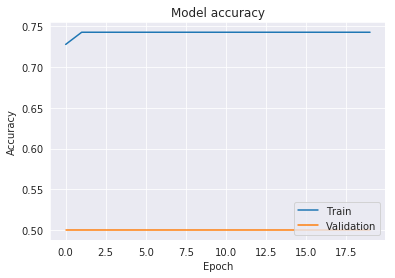

In [145]:
# model history is the resulting instance of the base model fit() function
# simple base model
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.show_history_accuracy(base_model_history)

**Note:**<br>
Regarding the result of the original dataset:<br>
The training curve is much higher compared to the validation one, means overfitting exists. Both don't show a real learning during the epochs sequences. The final accuracy value is already reached with the first epoch. So, this model architecture doesn't fit to the classification task.

According [Neural Network  FAQ](ftp://ftp.sas.com/pub/neural/FAQ3.html#A_over) "Overfitting is especially dangerous because it can easily lead to predictions that are far beyond the range of the training data with many of the common types of NNs. Overfitting can also produce wild predictions in multilayer perceptrons even with noise-free data." In other words, with overfitting our predictions are not reliable. In the mentioned FAQ several reasons and approaches to avoid overfitting are mentioned.<br>
In this project as one consequence, we are using the augmentation concept to get much more training images which fits better to the amount of training parameters of the network, afterwards the Keras Adam optimiser with decay is used without and with augmentation.

But in general, a better result is expected by having a data distribution of training-, validation- and testing-sets that fits to the state-of-the-art rule training/testing ration of 80/20 which leads to the training/validation/testing distribution of 60/20/20. In other words, other distributions than this original one will be evaluated as well.


Base model with rmsprop optimiser and augmentation:


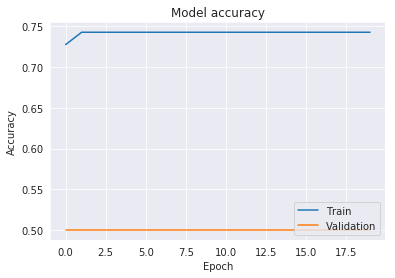

In [147]:
# augmented base model
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.show_history_accuracy(aug_base_model_history)


Base model with Adam optimiser:


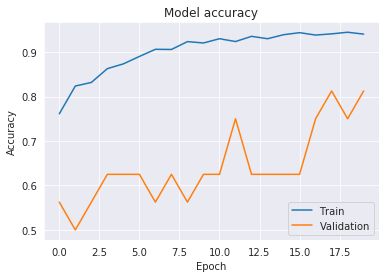

In [148]:
# base model with adam optimiser
print("\nBase model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(adam_base_model_history)

**Note:**<br>
The Adam optimiser showed a big improvement, but there is still overfitting.


Basic, augmented model with Adam optimiser:


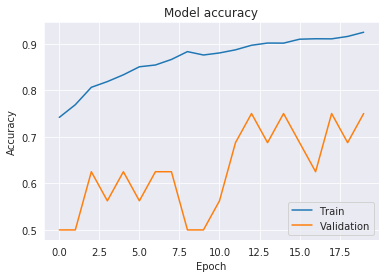

In [149]:
# base model with adam optimiser and augmentation
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(adam_aug_base_model_history)

**Note:**<br>
For this original dataset the basic model usage with Adam optimiser and the augmentation concept does not show a good accuracy result during all the epochs. Overfitting is still available. This model is not good for the given classfication task.


Improved model with Adam optimiser:


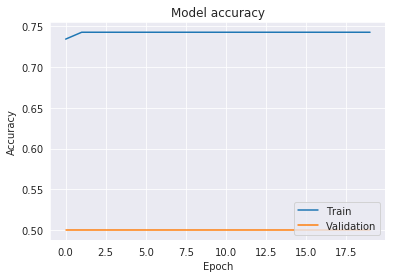

In [151]:
# improved model with adam optimiser
print("\nImproved model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(improved_model_history)


Improved, augmented model with Adam optimiser:


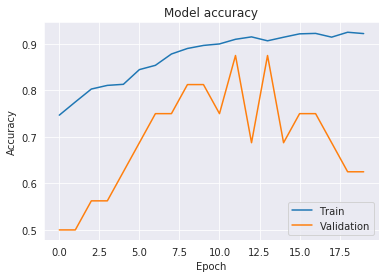

In [152]:
# improved, augmented model with adam optimiser
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(improved_model_aug_history)

**Note:**<br>
The validation training started to oscillate with epoch 10 and with epoch 13 it decreases up to the end.


ResNet50 transfer model with Adam optimiser and bottleneck features:


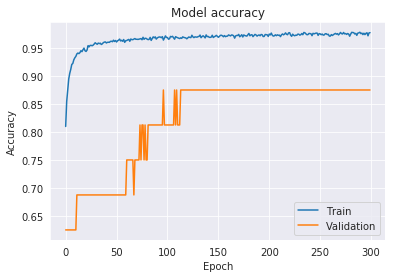

In [153]:
# ResNet50 transfer model
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_accuracy(resNet_transfer_model_history)

**Note:**<br>
With the RestNet50 transfer model using bottleneck features a fast high training accuracy appeared, but the validation accuracy does not follow in the same way.


Fine-tuned ResNet50 transfer model with Adam optimiser and augmentation:


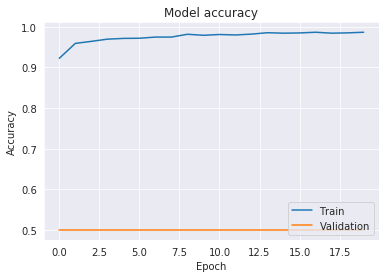

In [154]:
# Fine-tuned, augmented ResNet50 transfer  with adam optimiser
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_Class.show_history_accuracy(resNet_finetuned_model_aug_history)

**Note:**<br>
This result showed that there is no general rule always having an accuracy improvement by using a fine-tuned transfer model. A high overfitting exists during all the epochs.


InceptionV3 transfer model with Adam optimiser and bottleneck features:


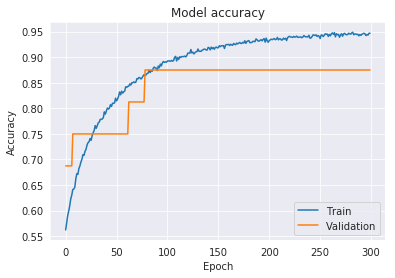

In [155]:
# InceptionV3 model with Adam optimiser and bottleneck features
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_accuracy(inception_transfer_model_history)

#### Learning during Training

Show the learning curves of loss function for training and validation.


Simple base model with rmsprop optimiser:


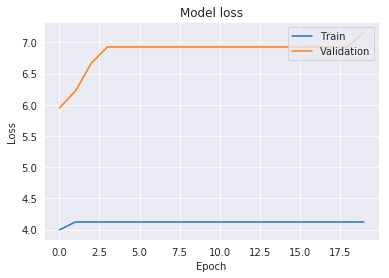

In [156]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.show_history_loss(base_model_history)

**Note:**<br>
In general, the training loss is the average of the losses over each batch of training data. There are 32 samples in each batch, which are processed independently. The model 'learns' over time, so regarding an epoch, at the beginning the learning loss value from the first batch is higher compared to the loss value of the final batch at the end. During validation, only the loss value of the epochs end is created, means a lower value shall exist. 

Original dataset:<br>
We see overfitting as well, with epoch 1 for the training set and epoch 3 for the validation set it is mainly complete, means both learning curves are mainly unchanged. Both diagrams show, that the model does not fit to the classification problem. In the next project parts using other dataset distributions, we will have a look, if the network architecture fits better.


Base model with rmsprop optimiser and augmentation:


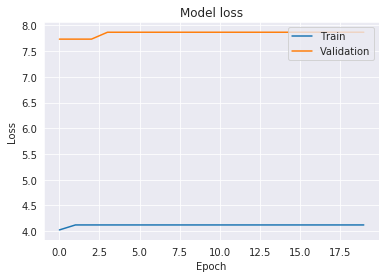

In [157]:
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.show_history_loss(aug_base_model_history)


Base model with Adam optimiser:


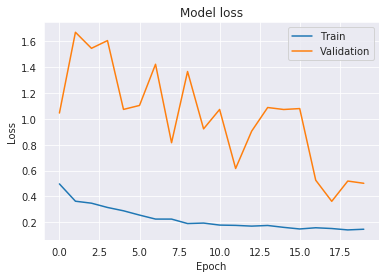

In [158]:
print("\nBase model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_base_model_history)


Basic, augmented model with Adam optimiser:


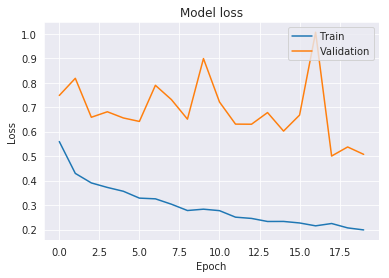

In [159]:
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_aug_base_model_history)


Improved model with Adam optimiser:


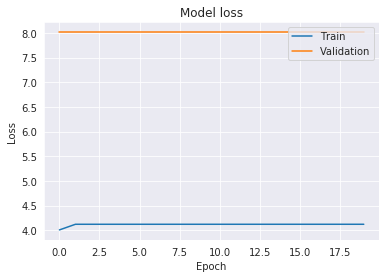

In [160]:
print("\nImproved model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_history)


Improved, augmented model with Adam optimiser:


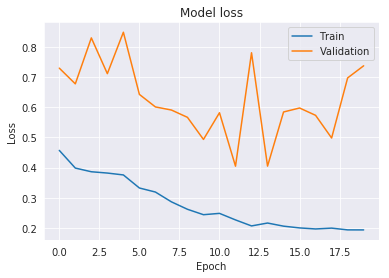

In [161]:
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_aug_history)


ResNet50 transfer model with Adam optimiser and bottleneck features:


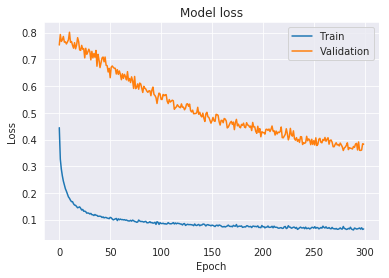

In [162]:
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(resNet_transfer_model_history)


Fine-tuned ResNet50 transfer model with Adam optimiser and augmentation:


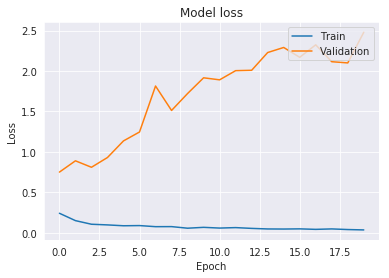

In [163]:
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_Class.show_history_loss(resNet_finetuned_model_aug_history)

**Note:**<br>
The validation set learning loss increases during the whole sequence, so, this model and its used parameters don't fit at all for the given distribution.


InceptionV3 transfer model with Adam optimiser and bottleneck features:


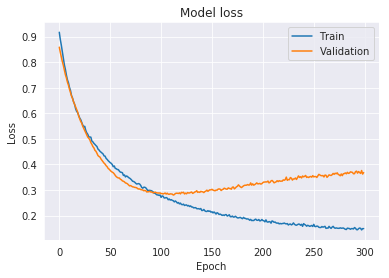

In [164]:
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(inception_transfer_model_history)

**Note:**<br>
The learning curves are smooth and for both datasets nearly the same up to epoch 100, but afterwards both curves diverges in the opposite direction. The validation curve is constantly increasing then, a sign of overfitting.

#### But first, some other metrics needed to compare all model results during the benchmark chapter ...

We need further metrics describing the performance, because a model may have a very good overall test accuracy, but the model is inadequate for the given classification task, because it is not taking care of the tasks domain properties. We would not realise this by using the overall accuracy value as only, single prediction metric.

**Precision** quantifies the binary precision. It is a ratio of true positives (images classified as pneumonia ones, and which are actually pneumonia) to all positives (all images classified as pneumonia ones, irrespective of whether that was the correct classification), in other words it is theratio of

TruePositives / (TruePositives + FalsePositives)

**Recall (sensitivity)** tells us what proportion of images that actually were pneumonia ones were classified by us as pneumonis ones. It is a ratio of true positives to all the images that were actually pneumonia ones, in other words it is the ratio of

TruePositives / (TruePositives + FalseNegatives)

A model's ability to precisely predict those that have a pneumonia is more important than the model's ability to recall those individuals. We can use **F-beta score** as a metric that considers both precision and recall. According scikit-learn, the F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. F – Measure is nothing but the harmonic mean of Precision and Recall.

Fβ=(1 + β2)  (precision⋅recall / ((β2⋅precision) + recall))

In particular, when β=0.5, more emphasis is placed on precision.

In [ ]:
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison,
# therefore we must reduce the 2D target arrays to 1D arrays.
# How do the data arrays look like? 
#test_targets[:,1]
#chest_pneumonia_predictions

In [165]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.get_other_metrics(test_targets, chest_pneumonia_predictions)


Simple base model with rmsprop optimiser:
Precision: 0.625
Recall: 1.000
F1 score: 0.769
F-beta score: 0.422  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Note:**<br>
According the sklearn documentation, the resulting values of 0 and the given _UndefinedMetricWarning_ show that there are vector elements of the _test_targets_ parameter which don't appear in the chest_pneumonia_predictions parameter. Why is this here the case, it shouldn't be? But it can be realised, that this always happened, if the model architecture and the associated hyperparameters don't show a proper training and learning (see model accuracy and learning diagrams of the training and validation sets). So, such values are already a hint, that the model architecture with its used configuration doesn't fit for the classification task.

**Note:**<br>
Regarding this metrics some more explanations are necessary:

- **Cohen's Kappa**<br>
  Its value is a statistical measure of the  inter-rater agreement. It can be used to get information about the imbalance of the dataset. Means in general, Cohen's Kappa takes the class distributions of the training data into account.
  

- **Confusion matrix**<br>
  In general, its architecture looks like
  ![confusion matrix](./images/ConfusionMatrix_architecture.png)
  
  It is a common method to get information about the classification performance.
  
  
- **Type 1 and Type 2 Errors**<br>
  There are two types of errors that can be identified here:

    Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).<br>
    Type 2 Error: The model predicted the instance to be the Negative class, but it is incorrect. This is False Negative (FN).
    
    Having a medical diagnostic prediction task, this type 2 error is most important, because of its severe consequence for the patient, not getting the needed therapy and being unmedicated.
    
    
- **ROC AUC curves**<br>
  The ROC – Receiver Operating Characteristic - curve is a curve between true positive rate and false positive rate for various threshold values. So, it is telling us about the 2 types of errors for all thresholds.  The more the area under the curve (AUC), the better is the performance of our model to distinguish the classes. Means, it is a prediction probability curve for the different classes. It informs us how good or bad our overall model performance is, mapping the _conditional_ measures sensitivity and specificity into one value. The ROC AUC diagram is used to compare the different classifier models comparing it with a random option existing by chance and visualised by a diagonal, dotted line.

  A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis. And the ideal value for AUC is 1. In general, such best case scenario will not be reached, means we don't have a clear distinction between the two classes NORMAL and PNEUMONIA. In other words, we have some overlapping of the class predictions and that introduces Type 1 and Type 2 errors to the model prediction. In general, the diagonal line visualises the random prediction.

In [166]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = base_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser: 0.257


In our case, we are looking to the 'positive' Pneumonia class. So, how does the ROC AUC diagram looks like to the given ROC AUC value above?

--- associated ROC AUC diagram of model type Basic CNN Model ---


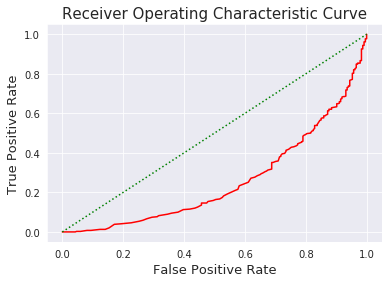

In [167]:
# see:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model")

**Note:**<br>
The ROC AUC curve is a worse one compared to the random, green dotted line which appeared by chance.

In [168]:
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.get_other_metrics(test_targets, aug_chest_pneumonia_predictions)



Base model with rmsprop optimiser and augmentation:
Precision: 0.625
Recall: 1.000
F1 score: 0.769
F-beta score: 0.422  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [170]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = aug_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser and augmentation: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser and augmentation: 0.289


--- associated ROC AUC diagram of model type Basic CNN Model with Augmentation ---


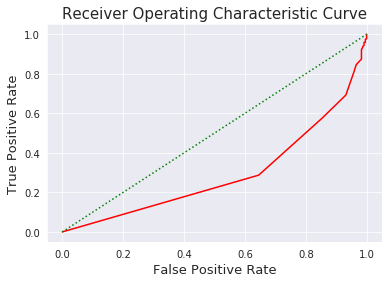

In [171]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Augmentation")

In [172]:
print("\nBase model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_chest_pneumonia_predictions)



Base model with Adam as optimiser:
Precision: 0.813
Recall: 0.962
F1 score: 0.881
F-beta score: 0.838  with beta=0.5

Cohens kappa: 0.632
Confusion matrix of the test data:
[[148  86]
 [ 15 375]]


In [173]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = adam_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with Adam optimiser: 0.934


--- associated ROC AUC diagram of model type Basic CNN Model with Adam optimiser ---


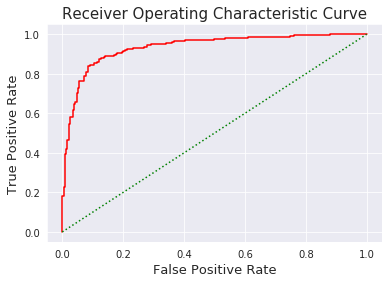

In [174]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Adam optimiser")

In [175]:
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_aug_chest_pneumonia_predict)



Basic, augmented model with Adam optimiser:
Precision: 0.881
Recall: 0.928
F1 score: 0.904
F-beta score: 0.876  with beta=0.5

Cohens kappa: 0.732
Confusion matrix of the test data:
[[185  49]
 [ 28 362]]


In [176]:
# ROC AUC
# predict probabilities for test set
yhat_probs = adam_aug_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic, augmented model with Adam optimiser: 0.951


--- associated ROC AUC diagram of model type Basic CNN Model with Adam optimiser and Augmentation ---


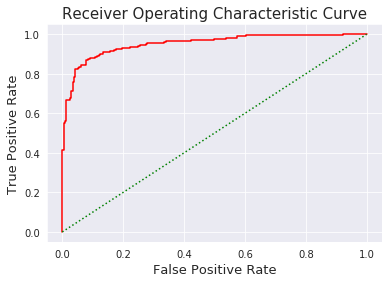

In [177]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Basic CNN Model with Adam optimiser and Augmentation")

In [179]:
print("\nImproved model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, improved_chest_pneumonia_predict_adam)



Improved model with Adam as optimiser:
Precision: 0.625
Recall: 1.000
F1 score: 0.769
F-beta score: 0.422  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [180]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_adam.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1])
print('ROC AUC Pneumonia class prediction of improved model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved model with Adam optimiser: 0.500


--- associated ROC AUC diagram of model type Improved CNN Model with Adam optimiser ---


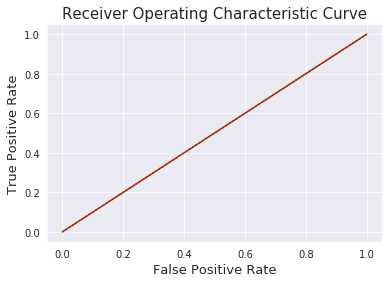

In [181]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Improved CNN Model with Adam optimiser")

**Note:**<br>
The own created 'improved' labelled model architecture using convolutional layers with the used hyperparameters has the same prediction as it exits by chance.

In [182]:
print("\nImproved, augmented model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, improved_chest_pneumonia_predict_aug)



Improved, augmented model with Adam as optimiser:
Precision: 0.873
Recall: 0.846
F1 score: 0.859
F-beta score: 0.829  with beta=0.5

Cohens kappa: 0.635
Confusion matrix of the test data:
[[186  48]
 [ 60 330]]


**Note:**<br>
The confusion matrix shows an unacceptable high value of false negatives: 60.

In [183]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_aug.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: 0.909


--- associated ROC AUC diagram of model type Improved CNN Model with Adam optimiser and Augmentation ---


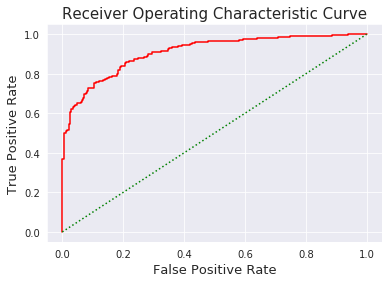

In [184]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Improved CNN Model with Adam optimiser and Augmentation")

In [185]:
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, resNet_chest_pneumonia_predict)



ResNet50 transfer model with Adam optimiser and bottleneck features:
Precision: 0.709
Recall: 0.995
F1 score: 0.828
F-beta score: 0.730  with beta=0.5

Cohens kappa: 0.364
Confusion matrix of the test data:
[[ 75 159]
 [  2 388]]


In [186]:
# ROC AUC
# predict probabilities for test set
yhat_probs = basic_resNet_model.predict(test_resNet, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of ResNet50 transfer model with Adam optimiser and bottleneck features: %.3f' % auc)

ROC AUC Pneumonia class prediction of ResNet50 transfer model with Adam optimiser and bottleneck features: 0.921


--- associated ROC AUC diagram of model type CNN Model with ResNet50 transfer learning, Adam optimiser and bottleneck features ---


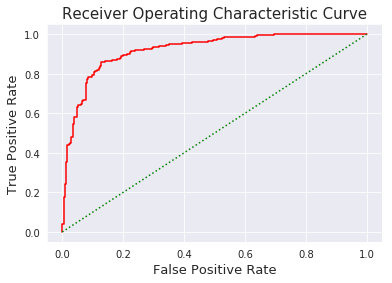

In [187]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                           modelname="CNN Model with ResNet50 transfer learning, Adam optimiser and bottleneck features")

In [ ]:
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
Evaluation_Class.get_other_metrics(test_targets, resNet_ft_transfer_chest_pneumonia_predict)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = resNet_ft_model.predict(test_tensors, verbose=0) 
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with fine-tuned ResNet50 transfer learning, Adam optimiser and Augmentation")

**Note:**<br>
ToDo: fix for a future AWS EC2 run, because of project deadline not possible anymore: visualise the ROC AUC value and curve. But regarding the results of the other modified datasets, it is expected to have a bad one as well, worth than the random case (green dotted line). 

By now, we will have a look if there is at least one possible pre-trained transfer learning model that leads to better training results - the Inception3 model. We use it with bottleneck features.

In [188]:
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, inception_chest_pneumonia_predict)



InceptionV3 transfer model with Adam optimiser and bottleneck features:
Precision: 0.789
Recall: 0.921
F1 score: 0.850
F-beta score: 0.792  with beta=0.5

Cohens kappa: 0.540
Confusion matrix of the test data:
[[138  96]
 [ 31 359]]


In [189]:
# ROC AUC
# predict probabilities for test set
yhat_probs = inception_model.predict(test_inception, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of InceptionV3 transfer model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of InceptionV3 transfer model with Adam optimiser: 0.859


--- associated ROC AUC diagram of model type CNN Model with InceptionV3 transfer learning with Adam optimiser and Augmentation ---


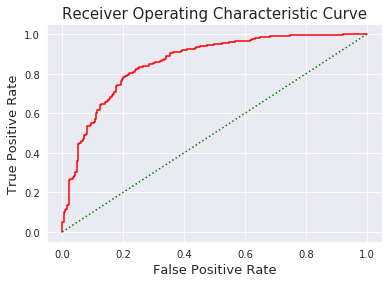

In [191]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with InceptionV3 transfer learning with Adam optimiser and Augmentation")

<a id='step14'></a>
## Step 14: Benchmark and Conclusion

Regarding the different evaluation results according test accuracy and because having a medical diagnosis prediction task the number of false negatives, it can be realised that 2 different models can be chosen for the classification issue of this given original data distribution.

If it is decided to have a higher prio on the lowest number of false negatives (type 2 error), the ResNet50 transfer model with Adam optimiser and bottleneck features - having only 2 false negatives, but its test accuracy is only 74.2%.

If the decision is taken to have the model with the highest test accuracy, then the basic, augmented model with Adam optimiser should be chosen: Its value is 87.7%.

Another insight of this evaluation is, that using a fine-tuned transfer learning model architecture with augmentation is no general, overall guarantee of having a better performance.

An overall description of the benchmark and conclusion, e.g. reagarding the insights by comparing all the models with the different distributions, is given in the final project document.

As a **future to do:** Better hyperparameter values must be found by having a better environment for machine learning algorithms (batch and epoch sizes together with the initialisation, changing learning rate and early stopping). My own hardware (not made for machine learning tasks) needed a whole week to do the calculations of this file and the local internet environment of the provider is an old standard compared to the one of the Silicon Valley and it is unstable. Means the AWS EC2 service has been disconnected few times a week and a lot of restarts were necessary. If the AWS service connection worked fine, the caculations of this file with random started hyperparameters needed approximately 2 days to be finished. So, hyperparameter tuning from Scikit-Learn with GridSearchCV or RandomizedCV as an alternative has not been done, because it is computational expensive having such a lot of parameters for the neural networks. With neural network optimisation, it is expected to get better prediction results.

As already mentioned, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.<br>
The same is valid by including the whole variety of ages, because this dataset is focussed on children images.

Furthermore, because of project deadline, the applicational algorithm accepting a file path to an unknown, future X-ray .jpg image and determine if it is a pneumonia image or not together with its testing code, has not been implemented yet. This would be possible, e.g. by usage of the [skimage](https://scikit-image.org/docs/dev/api/api.html) package or the [OpenCV cv2](https://docs.opencv.org/trunk/index.html) implementation.